In [397]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pyproj import Proj
import numpy 
from math import sqrt
from datetime import timedelta, datetime
R = 6371 #km

In [398]:
root_dir = Path("./")

In [399]:
stations = pd.read_csv(root_dir / "das_info.csv", index_col="index")
y0 = stations["latitude"].mean()
x0 = stations["longitude"].mean()
proj = Proj(f"+proj=aeqd +lon_0={x0} +lat_0={y0} +units=km")
stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x/1e3)
stations["id"] = stations.index
stations["id"] = stations["id"].astype(str)

In [400]:
config = {}
# config["vel"] = {"p": 5.5, "s": 5.5 / 1.73} ## Mammoth
config["vel"] = {"p": 6., "s": 6. / 1.73} ## Mammoth

In [401]:
event_path = Path("./catalog_gamma_debug.csv")
events = pd.read_csv(event_path, parse_dates=["time"])
event_true = {"event_id": "ci39550567", "time": datetime.fromisoformat("2021-02-12 23:57:13"), "latitude": 36.218, "longitude": -117.927, "depth_km": 3.1, "event_index": -1}
events = pd.concat([events, pd.DataFrame(event_true, index=[0])])
events[["x(km)", "y(km)"]] = events.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)

In [402]:
pick_path = Path("picks_phasenet_das/ci39550567.csv")
picks = pd.read_csv(pick_path, parse_dates=["phase_time"])
picks = picks.join(stations, on="channel_index", how="inner")

In [403]:
events

,event_id,time,longitude,latitude,depth_km,event_index,x(km),y(km)
0,ci39550567,2021-02-12 23:57:13.577,-118.123956,36.164025,0.0,0,69.165854,-169.495691
0,ci39550567,2021-02-12 23:57:13.000,-117.927000,36.218000,3.1,-1,86.829672,-163.344320


In [404]:
print((events["time"].iloc[-1] - picks["phase_time"].min().replace(tzinfo=None)).total_seconds())

-27.575


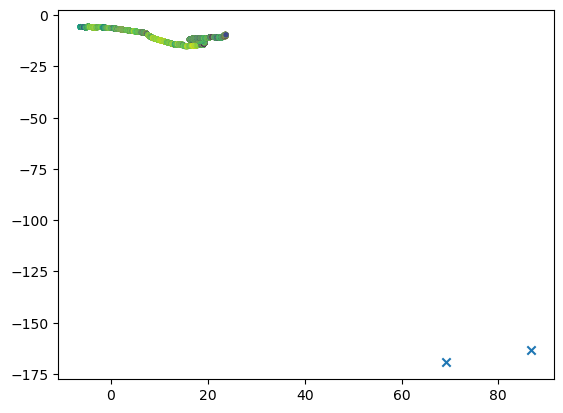

In [405]:
plt.figure()
# plt.scatter(stations["x(km)"], stations["y(km)"], marker='o', facecolors='none', edgecolors='k')
plt.scatter(picks["x(km)"], picks["y(km)"], c=picks["phase_score"], marker='.')
plt.scatter(events["x(km)"], events["y(km)"], marker='x')
plt.show()

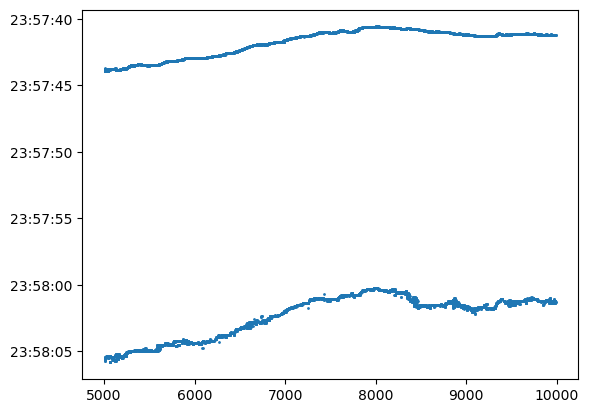

In [406]:
plt.figure()
plt.scatter(picks["channel_index"], picks["phase_time"], s=1)
plt.gca().invert_yaxis()
plt.show()

In [407]:
events

,event_id,time,longitude,latitude,depth_km,event_index,x(km),y(km)
0,ci39550567,2021-02-12 23:57:13.577,-118.123956,36.164025,0.0,0,69.165854,-169.495691
0,ci39550567,2021-02-12 23:57:13.000,-117.927000,36.218000,3.1,-1,86.829672,-163.344320


In [408]:
stations

,latitude,longitude,elevation_m,x(km),y(km),z(km),id
index,,,,,,,
4990,37.642440,-118.963959,2382.0,-6.304141,-5.693666,-2.382,4990
4989,37.642532,-118.963959,2382.0,-6.304133,-5.683435,-2.382,4989
4988,37.642624,-118.963959,2382.0,-6.304125,-5.673214,-2.382,4988
4987,37.642716,-118.963959,2382.0,-6.304118,-5.663018,-2.382,4987
4986,37.642808,-118.963959,2382.0,-6.304110,-5.652779,-2.382,4986
...,...,...,...,...,...,...,...
9982,37.606536,-118.623747,2226.0,23.733458,-9.647017,-2.226,9982
9983,37.606456,-118.623697,2225.0,23.737846,-9.655832,-2.225,9983
9984,37.606377,-118.623648,2226.0,23.742248,-9.664574,-2.226,9984


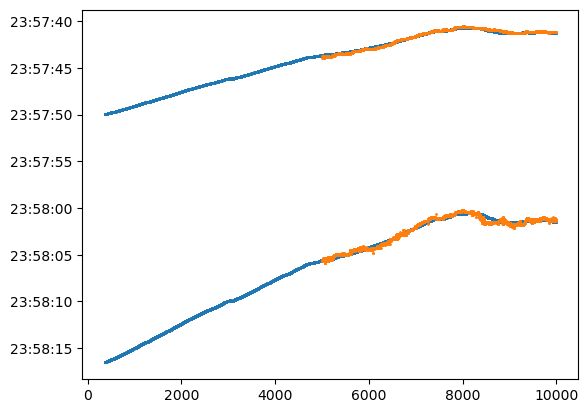

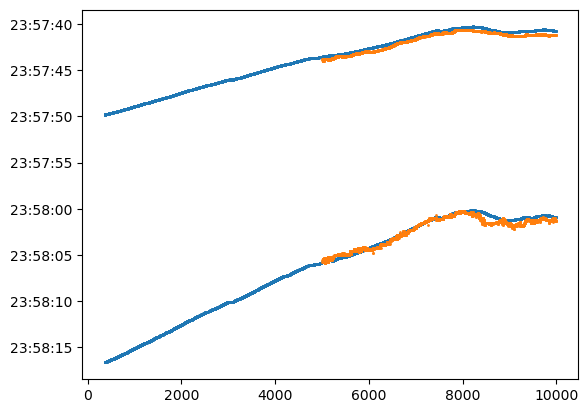

In [409]:
for _, event in events.iterrows():
    phase_picks_p = stations.copy()
    phase_picks_p["phase_time"] = phase_picks_p.apply(lambda x: timedelta(seconds = sqrt((x["x(km)"]-event["x(km)"])**2 + (x["y(km)"]-event["y(km)"])**2 + (x["z(km)"]-event["depth_km"])**2) / config["vel"]["p"]) + event["time"], axis=1)
    phase_picks_p["phase_type"] = "P"

    phase_picks_s = stations.copy()
    phase_picks_s["phase_time"] = phase_picks_s.apply(lambda x: timedelta(seconds = sqrt((x["x(km)"]-event["x(km)"])**2 + (x["y(km)"]-event["y(km)"])**2 + (x["z(km)"]-event["depth_km"])**2) / config["vel"]["s"]) + event["time"], axis=1)
    phase_picks_s["phase_type"] = "S"

    phase_picks = pd.concat([phase_picks_p, phase_picks_s])
    
    plt.figure()
    plt.scatter(phase_picks.index, phase_picks["phase_time"], s=1)
    plt.scatter(picks["channel_index"], picks["phase_time"], s=1)
    plt.gca().invert_yaxis()